In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from botorch.models import SingleTaskGP, ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.optim.optimize import optimize_acqf_list
from botorch.utils.transforms import unnormalize, normalize
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.utils.sampling import sample_simplex
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.sampling.pairwise_samplers import SobolQMCNormalSampler

In [22]:
noise_level = 0.2

bounds = torch.tensor([[-1.2], [1.2]])

def f(x, noise_level=noise_level):
    results = []
    for x_i in x:   
       sub_results = [
         (np.sin(6 *x_i[0])**3 * (1 - np.tanh(x_i[0] ** 2))) + (-1 + torch.rand(1)[0] * 2) * noise_level,
         .5 - (np.cos(5 * x_i[0] + 0.7)**3 * (1 - np.tanh(x_i[0] ** 2))) + (-1 + torch.rand(1)[0] * 2) * noise_level,
      ]
       results.append(sub_results)
    return torch.tensor(results, dtype=torch.float32)

def f_no_noise(x):
   return f(x, noise_level=0)

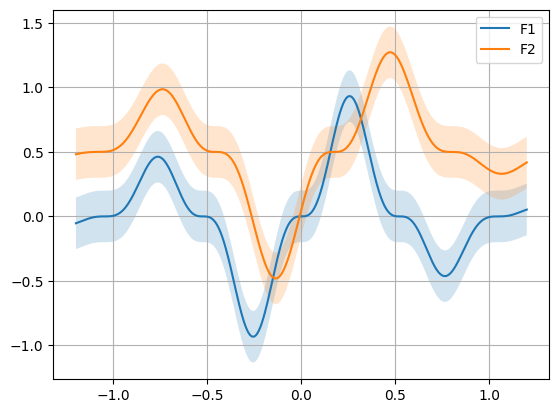

In [12]:
xs = np.linspace(bounds[0][0], bounds[1][0], 1000)
xs = xs.reshape((1000, -1))
ys_true = f(xs, noise_level=0).numpy()
plt.plot(xs, ys_true, label=["F1", "F2"])
# the fill method constructs a polygon of the specified color delimited by all the point
# in the xs and ys arrays.
plt.fill(np.concatenate([xs, xs[::-1]]),
         np.concatenate(([fx_i - 1 * noise_level for fx_i in ys_true],
                         [fx_i + 1 * noise_level for fx_i in ys_true[::-1]])),
         alpha=.2, ec="None")
plt.legend()
plt.grid()
plt.show()

In [13]:
for i in range(100):
    x_init = torch.tensor(bounds[0]) + torch.rand(3, 1) * (torch.tensor(bounds[1]) - torch.tensor(bounds[0]))
    ys_true = f(x_init, noise_level=0)
    ys_evaluated = f(x_init, noise_level=0.2)

    assert torch.abs(ys_true - ys_evaluated).max() < 0.2, torch.abs(ys_true - ys_evaluated).max()


C:\Users\nguyenb5\AppData\Local\Temp\ipykernel_14032\1708427996.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_init = torch.tensor(bounds[0]) + torch.rand(3, 1) * (torch.tensor(bounds[1]) - torch.tensor(bounds[0]))


In [14]:
def generate_initial_data(n_samples):
    x_init = torch.tensor(bounds[0]) + torch.rand(n_samples, 1) * (torch.tensor(bounds[1]) - torch.tensor(bounds[0]))
    y_init = f(x_init)
    y_init_true = f(x_init, noise_level=0)
    return x_init, y_init, y_init_true

In [15]:
train_x, train_y, train_y_true = generate_initial_data(3)
print(train_x)
print(train_y)
print(train_y_true)

tensor([[ 0.0653],
        [ 0.1277],
        [-0.8461]])
tensor([[0.1910, 0.3738],
        [0.4530, 0.5881],
        [0.2543, 0.7923]])
tensor([[0.0554, 0.3617],
        [0.3282, 0.4880],
        [0.3147, 0.8056]])


C:\Users\nguyenb5\AppData\Local\Temp\ipykernel_14032\98147212.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_init = torch.tensor(bounds[0]) + torch.rand(n_samples, 1) * (torch.tensor(bounds[1]) - torch.tensor(bounds[0]))


In [16]:
NUM_RESTARTS =  10
RAW_SAMPLES = 1024

standard_bounds = torch.tensor([[0.0], [1.0]])
MC_SAMPLES = 256

In [17]:
def initialize_model(train_x, train_y):
    
    train_x = normalize(train_x, bounds)
    models = []
    for i in range(train_y.shape[-1]):
        train_objective = train_y[:, i]
        models.append(
            SingleTaskGP(train_x, train_objective.unsqueeze(-1))
        )
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return mll, model

In [18]:
def generate_next_candidate(x, y, n_candidates=1):
    
    mll, model = initialize_model(x, y)
    fit_gpytorch_model(mll)

    sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)

    train_x = normalize(x, bounds)
    with torch.no_grad():
        pred = model.posterior(normalize(train_x,bounds)).mean
    
    acq_fun_list = []
    for _ in range(n_candidates):
        
        weights = sample_simplex(2).squeeze()
        objective = GenericMCObjective(
            get_chebyshev_scalarization(
                weights,
                pred
            )
        )
        acq_fun = qNoisyExpectedImprovement(
            model=model,
            objective=objective,
            sampler=sampler,
            X_baseline=train_x,
            prune_baseline=True,
        )
        acq_fun_list.append(acq_fun)
    

    candidates, _ = optimize_acqf_list(
        acq_function_list=acq_fun_list,
        bounds=standard_bounds,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
        options={
            "batch_limit": 5,
            "maxiter": 200,
        }
    )

    return unnormalize(candidates, bounds)


In [19]:
def plot_candidates(candidates):
        xs = np.linspace(bounds[0][0], bounds[1][0], 1000)
        xs = xs.reshape((1000, -1))
        ys_true = f(xs, noise_level=0).numpy()
        plt.plot(xs, ys_true, label=["F1", "F2"])
        # the fill method constructs a polygon of the specified color delimited by all the point
        # in the xs and ys arrays.
        plt.fill(np.concatenate([xs, xs[::-1]]),
                np.concatenate(([fx_i - 1 * noise_level for fx_i in ys_true],
                                [fx_i + 1 * noise_level for fx_i in ys_true[::-1]])),
                alpha=.2, ec="None")

        plt.scatter(candidates[:, 0], candidates[:, 1], c='blue', label='Candidates')
        plt.scatter(candidates[:, 0], candidates[:, 2], c='orange', label='Candidates')

        plt.legend()
        plt.grid()
        plt.show()

C:\Users\nguyenb5\AppData\Local\Temp\ipykernel_14032\98147212.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_init = torch.tensor(bounds[0]) + torch.rand(n_samples, 1) * (torch.tensor(bounds[1]) - torch.tensor(bounds[0]))


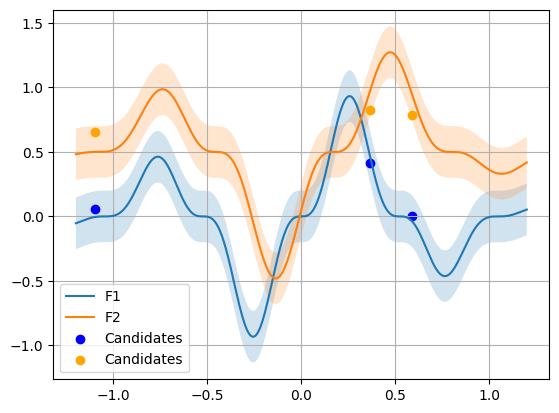

Iteration 0


C:\Users\nguyenb5\AppData\Local\Temp\ipykernel_14032\2684220359.py:8: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  SingleTaskGP(train_x, train_objective.unsqueeze(-1))


TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
n_iter = 16
n_start = 3
n_samples = 1

x,y,y_true = generate_initial_data(n_start)

plot_candidates(torch.cat([x,y], dim=1))

for i in range(n_iter):
    print(f"Iteration {i}")

    candidates = generate_next_candidate(x, -y, n_candidates = n_samples)

    print(f"Candidates: {candidates}")

    x = torch.cat([x, candidates])
    y = torch.cat([y, f(candidates)], dim=0)

    plot_candidates(torch.cat([x,y], dim=1))

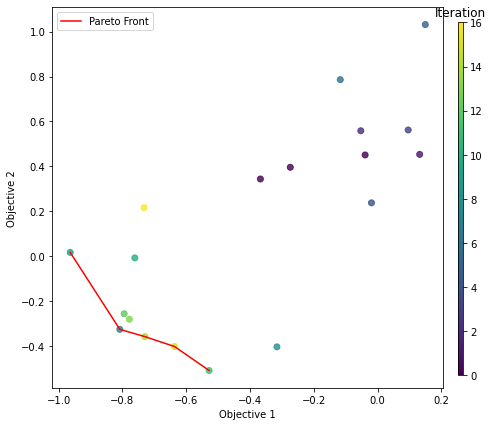

In [ ]:
from matplotlib.cm import ScalarMappable
import numpy as np
from matplotlib import pyplot as plt
from botorch.utils.multi_objective.pareto import is_non_dominated


fig, axes = plt.subplots(1, 1, figsize=(7, 7))
algos = ["qNEHVI"]
cm = plt.cm.get_cmap('viridis')

batch_number = torch.cat(
    [torch.zeros(n_start), torch.arange(1, n_iter+1).repeat(n_samples, 1).t().reshape(-1)]
).numpy()

sc = axes.scatter(y[:, 0], y[:, 1], c=batch_number, alpha=0.8)

y_sorted = y[y[:, 0].sort()[1]]

axes.plot(
    [_y[0] for non_dominated, _y in zip(is_non_dominated(-y_sorted), y_sorted) if non_dominated],
    [_y[1] for non_dominated, _y in zip(is_non_dominated(-y_sorted), y_sorted) if non_dominated],
    label="Pareto Front",
    c="r"
)


axes.set_xlabel("Objective 1")
axes.set_ylabel("Objective 2")
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)

sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")

axes.legend()
plt.show()
